In [43]:
!pip install openpyxl 
import os
import numpy as np
import pandas as pd
import librosa as lb
import IPython.display as ipd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_gunshot = pd.read_csv('gunshot_data_csv.csv')
raw_gunshot.head()

,Date,Time (GMT),Unnamed: 2,File name,File URL,Unnamed: 5,Owner,Gun Shot (Y/N),"Type of Sound (Gunshot, Unclear, etc.)"
0,6/29/2022,0:59:58,88244,Sample-1 (Tue Jun 28 17:59:55 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,Nilo,Y,Gunshot
1,6/29/2022,15:30:09,88244,Sample-1 (Wed Jun 29 08:30:07 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Rain
2,6/29/2022,15:34:39,88244,Sample-2 (Wed Jun 29 08:34:37 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Muffled sound
3,6/29/2022,15:50:33,88244,Sample-3 (Wed Jun 29 08:50:31 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Muffled sound
4,6/29/2022,17:03:12,88244,Sample-3 (Wed Jun 29 10:03:10 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Static/none


In [3]:
one_hot = pd.read_excel('one_hot_encoded_cic.xlsx')
one_hot.head()

,Unnamed: 0,Date,Time (GMT),Unnamed: 2,File name,File URL,Unnamed: 5,Owner,Gun Shot (Y/N),Class_Gunshot,Class_Not Gunshot
0,0,2022-06-29,00:59:58,88244,Sample-1 (Tue Jun 28 17:59:55 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,Nilo,Y,1,0
1,1,2022-06-29,15:30:09,88244,Sample-1 (Wed Jun 29 08:30:07 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1
2,2,2022-06-29,15:34:39,88244,Sample-2 (Wed Jun 29 08:34:37 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1
3,3,2022-06-29,15:50:33,88244,Sample-3 (Wed Jun 29 08:50:31 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1
4,4,2022-06-29,17:03:12,88244,Sample-3 (Wed Jun 29 10:03:10 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1


In [4]:
!pip install wget
import wget
import os
# download files from above csv
# manually download more gunshot examples from online datasets cited below
# TODO: Add links or better automate it
for index, row in one_hot.iterrows():
    URL = row['File URL']
    prefix = './gunshots/' if row['Gun Shot (Y/N)'] == 'Y' else './non-gunshots/'
    fileName = prefix + str(index) + '.wav'
    if os.path.exists(fileName):
        continue
    response = wget.download(URL, fileName)

In [5]:
def feature_extractor(path):
    data, simple_rate = lb.load(path)
    data = lb.feature.mfcc(y=data, n_mfcc=128)
    data = np.mean(data,axis=1)
    return data

In [24]:
import random
filepaths = []
num_gunshots = len(os.listdir('./gunshots/'))
non_gunshots = [{'isGunshot': False, 'file':x} for x in os.listdir('./non-gunshots/')]

# equal number of gunshots and non gunshots
filepaths.extend([{'isGunshot': True, 'file':x} for x in os.listdir('./gunshots/')])
filepaths.extend(random.sample(non_gunshots, num_gunshots))

In [44]:
import sklearn
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
# gather spectogram
for _ in range(3):
    rows = random.choice(filepaths)
    directory = './gunshots/' if rows['isGunshot'] else './non-gunshots'
    path = directory + '/' + str(rows['file'])
    x , sr = lb.load(path)
    
    spectogram = lb.stft(x)
    spectogram_db = lb.amplitude_to_db(abs(spectogram))
    print(f'spectogram count = {len(spectogram_db)}')
    
    zero_crossings = lb.zero_crossings(x, pad=False)
    print(f'total zero crossings = {sum(zero_crossings)}')
    
    #spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
    spectral_centroids = lb.feature.spectral_centroid(x, sr=sr)[0]
    # Computing the time variable for visualization
    frames = range(len(spectral_centroids))
    t = lb.frames_to_time(frames)
    # Normalising the spectral centroid 
    normlaized_spectral_centroid = normalize(spectral_centroids)
    print(f'Normalized Spectral centroid shape -> {normlaized_spectral_centroid.shape}')
    
    spectral_rolloff = lb.feature.spectral_rolloff(x, sr=sr)[0]
    normalized_spectral_rolloff = normalize(spectral_rolloff)
    print(f'Normalized Spectral Rolloff shape -> {normalized_spectral_rolloff.shape}')
    print('-------------------------------------')

spectogram count = 1025
total zero crossings = 26
Normalized Spectral centroid shape -> (87,)
Normalized Spectral Rolloff shape -> (87,)
-------------------------------------
spectogram count = 1025
total zero crossings = 2306
Normalized Spectral centroid shape -> (92,)
Normalized Spectral Rolloff shape -> (92,)
-------------------------------------
spectogram count = 1025
total zero crossings = 2590
Normalized Spectral centroid shape -> (86,)
Normalized Spectral Rolloff shape -> (86,)
-------------------------------------


In [25]:
x, y = [], []
for rows in tqdm(filepaths):
    try:
        directory = './gunshots/' if rows['isGunshot'] else './non-gunshots'
        path = directory + '/' + str(rows['file'])
        x.append(feature_extractor(path))
        y.append(1 if rows['isGunshot'] else 0)
    except Exception as e:
        print(e)
x = np.array(x)
y = np.array(y)
x.shape, y.shape

 19%|█▉        | 964/5052 [05:05<16:57,  4.02it/s]  d:\ProgramData\Anaconda3\envs\gae\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 19%|█▉        | 966/5052 [05:09<1:02:01,  1.10it/s]

100%|██████████| 5052/5052 [10:30<00:00,  8.01it/s] 


((5051, 128), (5051,))

In [26]:
y = to_categorical(y)
y.shape

(5051, 2)

In [27]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])



Number of samples for Train set : 3636
Number of samples for Validation set : 909
Number of samples for Test set : 506


In [28]:
model = Sequential(
                        [
                            layers.Dense(1000,activation='relu',input_shape=(128,)),
                            layers.Dense(750,activation='relu'),
                            layers.Dense(500,activation='relu'),
                            layers.Dense(250,activation='relu'),
                            layers.Dense(100,activation='relu'),
                            layers.Dense(50,activation='relu'),
                            layers.Dense(10,activation='relu'),
                            layers.Dense(2,activation='softmax')
                        ]
                   )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              129000    
                                                                 
 dense_9 (Dense)             (None, 750)               750750    
                                                                 
 dense_10 (Dense)            (None, 500)               375500    
                                                                 
 dense_11 (Dense)            (None, 250)               125250    
                                                                 
 dense_12 (Dense)            (None, 100)               25100     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 10)               

In [29]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
training = model.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=20)

Epoch 1/20
114/114 [==============================] - 3s 20ms/step - loss: 0.3691 - accuracy: 0.9211 - val_loss: 0.1305 - val_accuracy: 0.9659
Epoch 2/20
114/114 [==============================] - 2s 18ms/step - loss: 0.0886 - accuracy: 0.9684 - val_loss: 0.1274 - val_accuracy: 0.9659
Epoch 3/20
114/114 [==============================] - 2s 17ms/step - loss: 0.1105 - accuracy: 0.9689 - val_loss: 0.0882 - val_accuracy: 0.9681
Epoch 4/20
114/114 [==============================] - 2s 18ms/step - loss: 0.0707 - accuracy: 0.9722 - val_loss: 0.0796 - val_accuracy: 0.9747
Epoch 5/20
114/114 [==============================] - 2s 17ms/step - loss: 0.0634 - accuracy: 0.9761 - val_loss: 0.1181 - val_accuracy: 0.9659
Epoch 6/20
114/114 [==============================] - 2s 18ms/step - loss: 0.0614 - accuracy: 0.9766 - val_loss: 0.0798 - val_accuracy: 0.9725
Epoch 7/20
114/114 [==============================] - 2s 17ms/step - loss: 0.0622 - accuracy: 0.9755 - val_loss: 0.0709 - val_accuracy: 0.9747

In [30]:
train_hist = pd.DataFrame(training.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,0.369100,0.921067,0.130490,0.965897
1,0.088557,0.968372,0.127411,0.965897
2,0.110485,0.968922,0.088186,0.968097
3,0.070674,0.972222,0.079650,0.974697
4,0.063361,0.976073,0.118128,0.965897
5,0.061396,0.976623,0.079788,0.972497
6,0.062199,0.975523,0.070886,0.974697
7,0.061532,0.973872,0.092034,0.966997
8,0.066217,0.975523,0.122938,0.965897
9,0.053734,0.979373,0.076512,0.977998


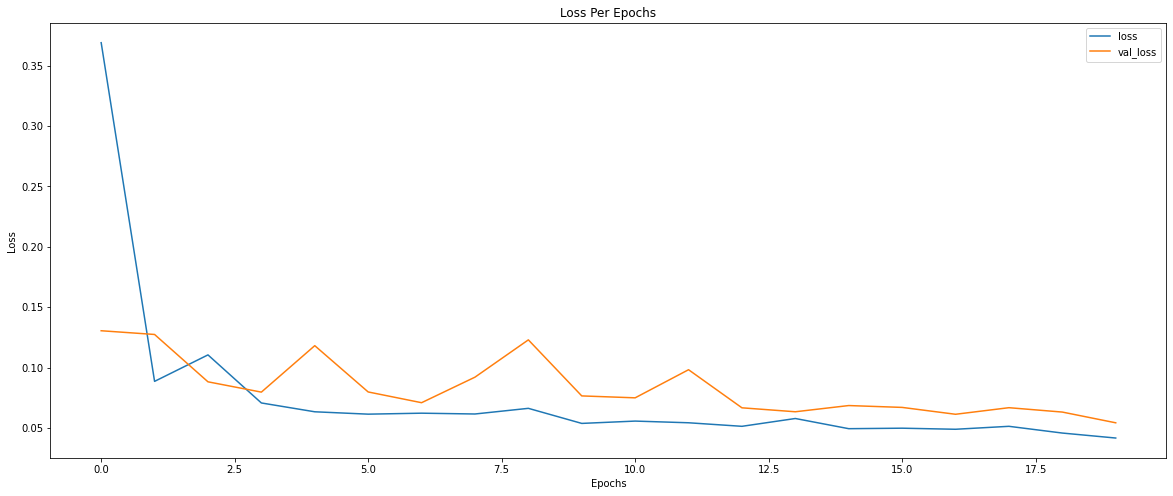

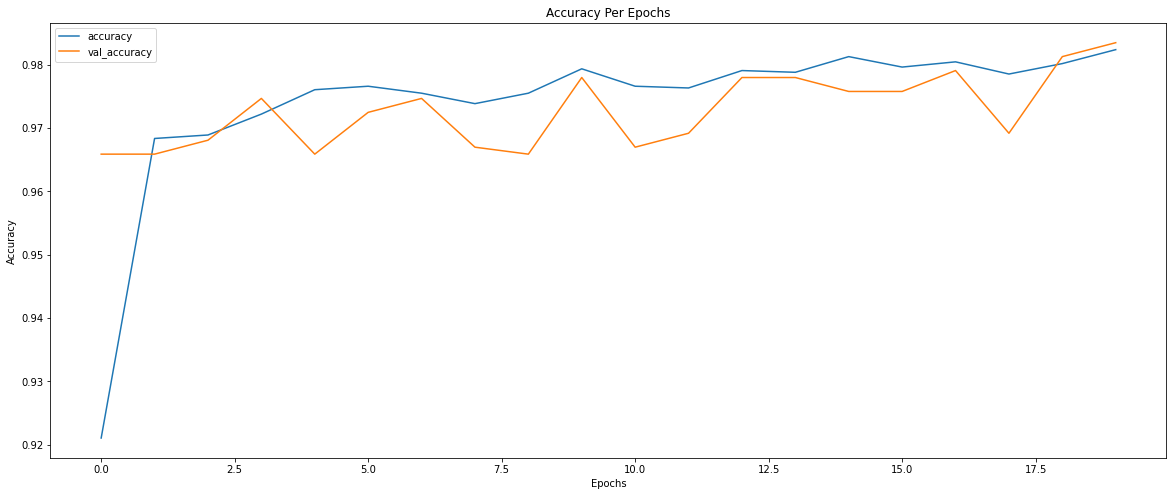

In [31]:
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [32]:
ytrue = np.argmax(ytest,axis=1)
ypred = np.argmax(model.predict(xtest),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[246   7]
 [  6 247]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.97      0.97       253
           1       0.97      0.98      0.97       253

    accuracy                           0.97       506
   macro avg       0.97      0.97      0.97       506
weighted avg       0.97      0.97      0.97       506



In [33]:
def predict(path, actual):
    audio = np.array([feature_extractor(path)])
    classid = np.argmax(model.predict(audio)[0])
    # print('Class predicted :','gunshot' if classid else 'not a gunshot', 'and was', 'gunshot' if actual else 'not a gunshot','\n\n')
    print(f"For file at {path}, class predicted : {'gunshot' if classid else 'not a gunshot'} and was { 'gunshot' if actual else 'not a gunshot'}")
    return ipd.Audio(path)


In [37]:
import random
samples = 5
for _ in range(samples):
    choice = random.choice(filepaths)
    directory = './gunshots/' if choice['isGunshot'] else './non-gunshots'
    path = directory + '/' + str(choice['file'])
    predict(path, choice['isGunshot'])    

For file at ./non-gunshots/1881.wav, class predicted : not a gunshot and was not a gunshot
For file at ./gunshots//IP_174A_S05.wav, class predicted : gunshot and was gunshot
For file at ./non-gunshots/2572.wav, class predicted : not a gunshot and was not a gunshot
For file at ./gunshots//IP_116B_S02.wav, class predicted : gunshot and was gunshot
For file at ./gunshots//4465.wav, class predicted : not a gunshot and was gunshot
